### **SOW-MKI49-2019-SEM1-V: NeurIPS**
#### Project: Neurosmash

This is the info document on the (updated*) Neurosmash environment that you will be using for your project. It contains background info and skeleton code to get you started.

### Project

In the next 4 + 1 weeks, you will be working exclusively on your project in the practicals. The goal is to take what has been discussed in class and what you have already worked on in the earlier practicals, and apply them on a RL problem in a novel environment. Note that while the earlier practicals were intended to give you the opportunity to gain experience with various RL topics and were not graded, your project will constitute 50% of your final grade.

Your project grade will be based on the following components:
- Online demonstration
- Source code
- Written report

These components will be evaluated based on performance, creativity, elegance, rigor and plausibility.

While you can use the material from earlier practicals (e.g., REINFORCE, DQN, etc.) as a boilerplate, you are also free to take any other approach be it imitation learning or world models for your project.

In addition to the practical sessions, we will provide additional support in the coming four weeks. You can email any of us to set up an appointment for discussing your project.

### Environment

Briefly, there are two agents: Red and Blue. Red is controlled by you. Blue is controlled by the environment "AI".* Both agents always run forward with a speed of 3.5 m/s*. If one of them gets within the reach of the other (a frontal sphere with 0.5 m radius), it gets pushed away automatically with a speed of 3.5 m/s. The only thing that the agents can do is to turn left or right with an angular speed of 180 degrees/s. This means that there are three possible discrete actions that your agent can take every step: Turn nowhere, turn left and turn right. For convenience, there is also a fourth built-in action which turns left or right with uniform probability. An episode begins when you reset the environment and ends when one of the agents fall off the platform. At the end of the episode, the winning agent gets a reward of 10 while the other gets nothing. Therefore, your goal is to train an agent who can maximize its reward by pushing the other agent off the platform or making it fall off the platform by itself.

* None that all times are simulation time. That is, 0.02 s per step when timescale is set to one.

* Basically, Blue is artificial but not really intelligent. What it does is that every 0.5 s, it updates its destination to the current position of Red plus some random variation (a surrounding circle with a radius of 1.75 m) and smoothly turns to that position.

### *Updates

* There has been several small changes made to the lite version based on your feedback. Most notable ones are:
- Bugs have (hopefully) been completely eliminated. Any remaining bug/glitch that your agent "learns" exploit will be considered fair game.

- TCP/IP interface has been made more robust (you can now stop and start the simulation with the gui. no need to quit and rerun the environment anymore to reset it if something goes wrong.)
- Animations/graphics have been updated (you can now tell what is going on more easily. agents actually fall down, etc.)
- Last but not least, size and timescale settings have been added (you can now change the resolution and the speed of the environment to make the simulation run faster). In other words:

Size => This is the size of the texture that the environment is rendered. This is set to 784 by default, which will result in a crisp image but slow speed. You can change the size to a value that works well for your environment should not go too low.

Timescale => This is the simulation speed of the environment. This is set to 1 by default. Setting it to n will make the simulation n times faster. In other words, less (if n < 1) or more (if n > 1) simulation time will pass per step. You might want to increase this value to around 10 if you cannot train your models fast enough so that they can sample more states in a shorter number of steps at the expense of precision.

### Misc. FAQs

Q: Can we get HCP access?  
A: I will try provide access to the AI HPC cluster if you require additional resources. If this is something that you would like, please contact me. Note however that you should use the cluster for training your final model and not development.

Q: Will the environment code be shared?  
A: Yes. I will share the entire unityproject at the end of the course (but without the 3D agent models).

Q: Is there a environment version that can be played with a mouse/keyboard?  
A: No but I will make one and update Brightspace when I have some free time.

Q: I found a bug/glitch. What should I do?  
A: Please let me know and I will fix it. Do note however that any updates from this point on will be optional to adopt. That is, you can keep working on the current environment if you so wish or think that updating will disadvantage you in any way.

### Skeleton code

- You should first add the Neurosmash file to your working directory or Python path.

In [6]:
import Neurosmash

# These are the default environment arguments. They must be the same as the values that are set in the environment GUI.
ip         = "127.0.0.1" # Ip address that the TCP/IP interface listens to
port       = 13000       # Port number that the TCP/IP interface listens to
size       = 768         # Please check the Updates section above for more details
timescale  = 1           # Please check the Updates section above for more details

agent = Neurosmash.Agent() # This is an example agent.
                           # It has a step function, which gets reward/state as arguments and returns an action.
                           # Right now, it always outputs a random action (3) regardless of reward/state.
                           # The real agent should output one of the following three actions:
                           # none (0), left (1) and right (2)

environment = Neurosmash.Environment() # This is the main environment.
                                       # It has a reset function, which is used to reset the environment before episodes.
                                       # It also has a step function, which is used to which steps one time point
                                       # It gets an action (as defined above) as input and outputs the following:
                                       # end (true if the episode has ended, false otherwise)
                                       # reward (10 if won, 0 otherwise)
                                       # state (flattened size x size x 3 vector of pixel values)
                                       # The state can be converted into an image as follows:
                                       # image = np.array(state, "uint8").reshape(size, size, 3)
                                       # You can also use to Neurosmash.Environment.state2image(state) function which returns
                                       # the state as a PIL image

In [21]:
# The following steps through an entire episode from start to finish with random actions (by default)

end, reward, state = environment.reset()

while (end == 0):
    action = agent.step(end, reward, state)
    end, reward, state = environment.step(action)

# Let's run it a few more steps so that the things have time to settle down

for i in range(100):
    action = agent.step(end, reward, state)
    end, reward, state = environment.step(action)

#environment.state2image(state)

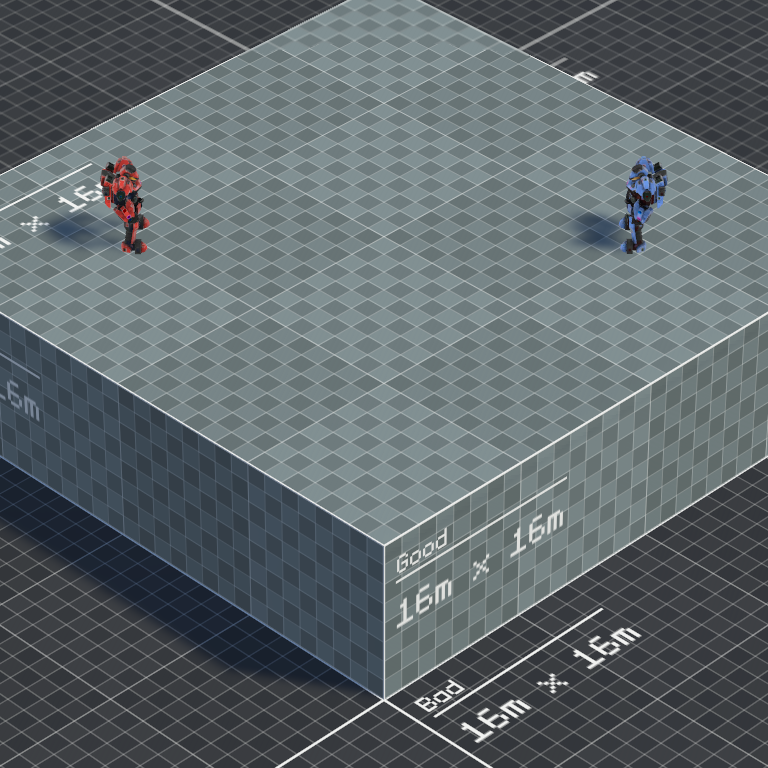

In [9]:
# Let's also do it step by step while displaying the state

end, reward, state = environment.reset()

#environment.state2image(state)

In [45]:
import numpy as np
from torch import nn
import torch
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = torch.nn.Conv2d(3, 8, kernel_size=4, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.conv2 = torch.nn.Conv2d(8, 16, kernel_size=4, stride=1, padding=1)
        
        self.conv3 = torch.nn.Conv2d(16, 32, kernel_size=4, stride=1, padding=1)
        
        self.conv3 = torch.nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=1)
        
        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(768*768*3, 256)
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(256, 2)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        print(x.shape)
        x = self.hidden(x)
        
        return x

In [61]:
action = agent.step(end, reward, state)
end, reward, state = environment.step(action)
# state = 768*768*3
#state_1 = environment.state2image(state)
#print(type(np.array(environment.state2image(state))[1][1][1]))
x = torch.tensor([np.swapaxes(np.array(environment.state2image(state), dtype='d'),0,2)])
#print(x)
my_network = Network()
my_network.forward(x)

tensor([[[[ 60.,  60.,  60.,  ..., 164., 124.,  61.],
          [ 60.,  59.,  59.,  ..., 147., 102.,  74.],
          [ 59.,  59.,  60.,  ...,  93.,  93.,  94.],
          ...,
          [ 60.,  60.,  60.,  ...,  92.,  93.,  95.],
          [ 60.,  60.,  60.,  ..., 147., 103.,  74.],
          [ 60.,  60.,  60.,  ..., 164., 124.,  62.]],

         [[ 63.,  63.,  63.,  ..., 165., 125.,  63.],
          [ 63.,  63.,  62.,  ..., 148., 104.,  76.],
          [ 63.,  62.,  63.,  ...,  95.,  95.,  96.],
          ...,
          [ 63.,  63.,  63.,  ...,  95.,  95.,  97.],
          [ 63.,  63.,  63.,  ..., 149., 105.,  76.],
          [ 63.,  63.,  63.,  ..., 165., 125.,  64.]],

         [[ 67.,  67.,  67.,  ..., 165., 126.,  67.],
          [ 67.,  67.,  67.,  ..., 148., 106.,  79.],
          [ 67.,  67.,  67.,  ...,  96.,  97.,  99.],
          ...,
          [ 67.,  67.,  67.,  ...,  96.,  98., 100.],
          [ 67.,  67.,  67.,  ..., 149., 107.,  80.],
          [ 67.,  67.,  67.,  ...

RuntimeError: Expected object of scalar type Double but got scalar type Float for argument #2 'weight' in call to _thnn_conv2d_forward

In [12]:
# etc.